# Physics 390 - Climate Modelling

The first stage of modelling is to import relevant modules into the notebook. After this, data can be loaded in for each data file provided.


In [15]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from datetime import datetime 
from datetime import timedelta 
from scipy import interpolate

In [16]:
# Load satellite data

# Data directories
SATELLITE_DATA_DIR = "Satellite Data/"

# Full satellite data file paths
cloud_fraction_phase_file = SATELLITE_DATA_DIR + '3D_CloudFraction_Phase330m_200606-201803_avg_CFMIP2_sat_3.1.2.nc'
cloud_fraction_file = SATELLITE_DATA_DIR + '3D_CloudFraction330m_200606-201803_avg_CFMIP2_sat_3.1.2.nc'
ECMWF_ta_plevels_file = SATELLITE_DATA_DIR + 'ECMWF_ta_plevels_2001_2018.nc'
map_low_high_mid_high_file = SATELLITE_DATA_DIR + 'MapLowMidHigh330m_200606-201803_avg_CFMIP2_sat_3.1.2.nc'

# Load satellite data into variables with read access
cloud_fraction_phase_data = Dataset(cloud_fraction_phase_file, 'r')
cloud_fraction_data = Dataset(cloud_fraction_file, 'r')
ECMWF_ta_plevels_data = Dataset(ECMWF_ta_plevels_file, 'r')
map_low_high_mid_high_data = Dataset(map_low_high_mid_high_file, 'r')

In [17]:
# Load model data

# Data directories
MODEL_DATA_DIR = "Model Data/"

# Full model data file paths
cl_data_file = MODEL_DATA_DIR + 'clcalipso_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'
clt_data_file = MODEL_DATA_DIR + 'cltcalipso_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'
cl_ice_data_file = MODEL_DATA_DIR + 'clcalipsoice_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'
cl_liq_data_file = MODEL_DATA_DIR + 'clcalipsoliq_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'
ta_data_file = MODEL_DATA_DIR + 'ta_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'

# Load model data into variables with readable access
cl_data = Dataset(cl_data_file, 'r')
clt_data = Dataset(clt_data_file, 'r')
cl_ice_data = Dataset(cl_ice_data_file, 'r')
cl_liq_data = Dataset(cl_liq_data_file, 'r')
ta_data = Dataset(ta_data_file, 'r')

In [19]:
## Declare some global variables
FIG_WIDTH = 10
FIG_HEIGHT = 5

### Helper functions used during the experiment:

In [18]:
# Declare some helper methods for easy viewing of data

# Display the names of all data points in the dataset and the number of data points in that set
def print_dataset_overview(dataset):
    print("Variables and Number of Data Points:")
    for key in dataset.variables.keys():
        print("\t", key, ": ", len(dataset.variables[key][:]), " data points")
    print("\n")

# Display the data for the variable name provided
def print_data_points(dataset, variable_name):
    print(variable_name, ":")
    print(dataset.variables[variable_name][:])
    print("\n")

def print_variables(dataset):
    for key in dataset.variables.keys():
        print(key, ": ", dataset.variables[key])
        print("\n")

In [241]:
# Helper function to extract time data for summer and winter periods
# Note this also selects data only between 2006 and 2014 as this is the largest region of overlap 
# between the modelled and satellite data

# Generate a mask to see which times fall within the given season
def generate_seasonal_time_mask(times, season, reference_datetime = datetime(year=1, month=1, day=1, hour=0, minute=0, second=0), increment = "days"):
    # Units of time: "days since 0001-01-01 00:00:00"
    times_mask = []

    # Find a subset of cloud cover values for each season
    for i in range(0, len(times)):
        # Find the month corresponding to the current time
        if (increment == "days"):
            time_delta = timedelta(days=int(times[i]))
        else :
            time_delta = timedelta(hours=int(times[i]))

        month = (reference_datetime + time_delta).month
        year = (reference_datetime + time_delta).year

        # Check to see if this time falls within desired range of years
        if (year >= 2006 and year <= 2014):
            # Time falls between December - February
            if (season == "summer"):
                times_mask.append(True if (month == 12 or month == 1 or month == 2) else False)

            # Time falls between June - August
            if (season == "winter"):
                times_mask.append(True if (month == 6 or month == 7 or month == 8) else False)

            if (season == None):
                times_mask.append(True)

        # Do not select this time if it is not within the desired range of years
        else:
            times_mask.append(False)

    return np.array(times_mask)


In [30]:
# Helper function to find the coordinate of the first and last indices of values within the range (min, max)
def find_min_max_indices(values, min_value, max_value):
    i = 0
    while(i < len(values) and values[i] < min_value):
        i += 1
    min_index = i
    
    while(i < len(values) and values[i] < max_value):
        i += 1
    max_index = i
    
    return [min_index, max_index]    

<br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> 

# Altitude vs Latitude Cloud Fraction

## Seasonal Cloud Cover: Model Data 

Data points in the $clcalipso$ dataset are of the form $clcalipso[time][alt][lat][lon]$. To plot altitude vs latitude, the dataset must be averaged across all longitudal data points. Please note that most array manipulation operations are done on a single line to conserve program memory, as this method does not generate intermediary arrays. I realise this unfortunately reduces readability of the code.

In [23]:
# Global variables used for plotting

ALT_MIN = np.min(cl_data.variables["alt40"][:])
ALT_MAX = np.max(cl_data.variables["alt40"][:])

LAT_MIN = np.min(cl_data.variables["lat"][:])
LAT_MAX = np.max(cl_data.variables["lat"][:])

In [180]:
# First, extract all data points during the summer then average over all longitudes and all times
summer_mask = generate_seasonal_time_mask(cl_data.variables["time"][:], "summer")
avg_model_summer_cloud_cover = np.mean(np.mean(cl_data.variables["clcalipso"][summer_mask], axis = 3), axis=0)[::-1]

winter_mask = generate_seasonal_time_mask(cl_data.variables["time"][:], "winter")
avg_model_winter_cloud_cover = np.mean(np.mean(cl_data.variables["clcalipso"][winter_mask], axis = 3), axis=0)[::-1]

C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  


### Converting Pressure to Altitude for Temperature Contours

In [210]:
from math import e, log

# Helper function to convert a pressure (Pa) to an altitude (m)
def pressure_to_altitude(pressure):
    g_0 = 9.80665 # gravitational acceleration
    R = 8.3145 # universal gas constant
    M = 0.02896 # molar mass of Earth's air

    P_0 = 101325 # Pressure at level 0 (Pa)
    P_1 = 22632 # Pressure at level 1 (Pa)
    P_2 = 5474 # Pressure at level 2 (Pa)

    if (pressure <= P_0 and pressure > P_1):
        # Evaluate using b = 0, temperature lapse rate is non-zero

        P_b = P_0 # Static Pressure (Pa)
        T_b = 288.15 # Standard temperature (K)
        h_b = 0 # Height above sea-level (m)
        L_b = -0.0065 # Temperature lapse rate (K/m)

        numerator = T_b * e ** -(log(pressure/P_b) / ((g_0*M) / (R*L_b))) - T_b
        h = (numerator/L_b) + h_b

    elif (pressure <= P_1 and pressure > P_2):
        # Evaluate using b = 1, temperature lapse rate is zero
        
        P_b = P_1 # Static Pressure (Pa)
        T_b = 216.65 # Standard temperature (K)
        h_b = 11000 # Height above sea-level (m)

        numerator = log(pressure/P_b) * R * T_b
        h = (numerator / (-g_0*M)) + h_b

    else: 
        # Pressure corresponds to an altitude outside of our range of interest.
        return -1
    
    return h

# Generate an array of altitudes and a mask storing which pressures have valid altitudes
def get_altitudes_and_mask_from_pressures(pressures):

    mask = []
    altitudes = []

    for pressure in pressures:
        altitude = pressure_to_altitude(pressure)

        if (altitude != -1):
            altitudes.append(altitude)

        mask.append(altitude != -1)

    return np.array(altitudes), np.array(mask)


In [233]:
# Convert pressures to Pa from hPa then pressures to altitudes
model_altitudes, altitude_mask = get_altitudes_and_mask_from_pressures(ta_data.variables["lev"][:] * -100)
model_latitudes = ta_data.variables["lat"][:]

# Extract time period overlapping with satellite data collection and only valid altitudes from temperature data
# then average over time and longitude and convert to celsius
model_summer_temperatures = np.mean(np.mean(ta_data.variables["ta"][summer_mask, altitude_mask, :, :], axis = 3), axis=0) - 273
model_winter_temperatures = np.mean(np.mean(ta_data.variables["ta"][winter_mask, altitude_mask, :, :], axis = 3), axis=0) - 273

C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  import sys
C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  


In [179]:
def plot_model_alt_lat_cloud_cover(sat_cloud_cover, temperatures, title, size=[LAT_MIN, LAT_MAX, ALT_MIN, ALT_MAX], color_bar_label="Percentage Cloud Cover"):
    # Plot cloud coverage
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    color_map = plt.imshow(sat_cloud_cover, aspect="auto", interpolation='bilinear', 
                        extent=size)
    color_map.set_cmap("coolwarm")
    cbar = plt.colorbar()
    cbar.set_label(color_bar_label)
    
    # Plot temperature contours
    CS = plt.contour(model_latitudes, model_altitudes, temperatures, linewidths = (2), colors = ("white"))
    plt.clabel(CS, inline=1, fontsize=12)
    
    plt.title(title)
    plt.xlabel("Latitude")
    plt.ylabel("Altitude (km)")    
    return color_map


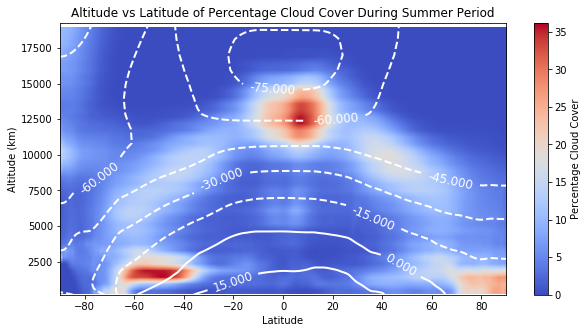

In [234]:
title = "Altitude vs Latitude of Percentage Cloud Cover During Summer Period"
plot_model_alt_lat_cloud_cover(avg_model_summer_cloud_cover, model_summer_temperatures, title)

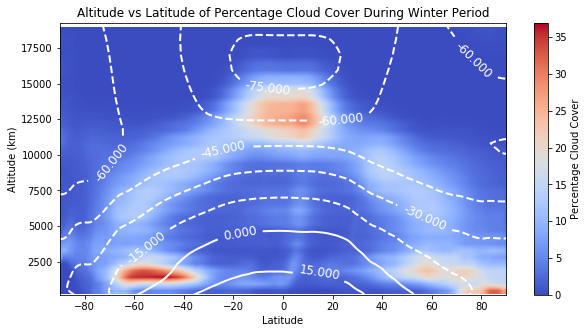

In [235]:
# Plot the altitude vs latitude for winter period for the model
title = "Altitude vs Latitude of Percentage Cloud Cover During Winter Period"
plot_model_alt_lat_cloud_cover(avg_model_winter_cloud_cover, model_winter_temperatures, title)

<br /> <br />
## Seasonal Cloud Cover: Satellite Data
The same helper function can be used for satellite data to extract seasonal data across the overlapping time period from 2006-2014. The following plots display altitude and latitude during summer and winter periods measured by the calipso satellite.

In [31]:
# Convert cloud coverage to a percentage
raw_sat_cloud_coverage_alt_lat = cloud_fraction_data.variables["clcalipso"][:]

SAT_LAT_MIN = -80
SAT_LAT_MAX = 80

# Extract only the values with latitudes between -80 and 80
sat_lat_min_index, sat_lat_max_index = find_min_max_indices(cloud_fraction_data.variables["latitude"][:], SAT_LAT_MIN, SAT_LAT_MAX)

sat_cloud_coverage_alt_lat = raw_sat_cloud_coverage_alt_lat[:, :, sat_lat_min_index:sat_lat_max_index, :]
sat_latitudes_alt_lat = cloud_fraction_data.variables["latitude"][sat_lat_min_index:sat_lat_max_index]

# Convert satellite latitudes to metres for compatibility with model
sat_altitudes_alt_lat = cloud_fraction_data.variables["alt_mid"][:] * 1000

SAT_ALT_MIN = np.min(sat_altitudes_alt_lat)
SAT_ALT_MAX = np.max(sat_altitudes_alt_lat)

SIZE = [SAT_LAT_MIN, SAT_LAT_MAX, SAT_ALT_MIN, SAT_ALT_MAX]

# Times in this dataset are measured relative to this date time
SAT_REFERENCE_DATETIME = datetime(year=2000, month=1, day=1, hour=0, minute=0, second=0)

In [183]:
# Extract seasonal cloud cover for altitude and latitude and convert to a percentage
sat_summer_mask = generate_seasonal_time_mask(cloud_fraction_data.variables["time"][:], "summer", SAT_REFERENCE_DATETIME)
avg_sat_summer_cloud_cover = np.mean(np.mean(sat_cloud_coverage_alt_lat[sat_summer_mask], axis = 3), axis=0)[::-1] * 100

sat_winter_mask = generate_seasonal_time_mask(cloud_fraction_data.variables["time"][:], "winter", SAT_REFERENCE_DATETIME)
avg_sat_winter_cloud_cover = np.mean(np.mean(sat_cloud_coverage_alt_lat[sat_winter_mask], axis = 3), axis=0)[::-1] * 100

In [245]:
# Extract ECMWF time values during summer
ECMWF_REFERENCE_DATETIME = datetime(year=1900, month=1, day=1, hour=0, minute=0, second=0)
ECMWF_season_mask = generate_seasonal_time_mask(ECMWF_ta_plevels_data.variables["time"][:], "summer", ECMWF_REFERENCE_DATETIME, "hours")

# Convert pressures from millibars to Pascals then to altitudes
sat_altitudes, sat_altitude_mask = get_altitudes_and_mask_from_pressures(ECMWF_ta_plevels_data.variables["level"][:] * 100)
sat_latitudes = ECMWF_ta_plevels_data.variables["latitude"][:]

# Average temperatures across summer times and longitudes then convert from K to degrees C
sat_summer_temperatures = np.mean(np.mean(ECMWF_ta_plevels_data.variables["t"][ECMWF_season_mask, sat_altitude_mask, :, :], axis = 3), axis=0) - 273

(28, 721)


In [246]:
# Average temperatures across winter times and longitudes then convert from K to degrees C
ECMWF_season_mask = generate_seasonal_time_mask(ECMWF_ta_plevels_data.variables["time"][:], "winter", ECMWF_REFERENCE_DATETIME, "hours")
sat_winter_temperatures = np.mean(np.mean(ECMWF_ta_plevels_data.variables["t"][ECMWF_season_mask, sat_altitude_mask, :, :], axis = 3), axis=0) - 273

In [255]:
def plot_satellite_alt_lat_cloud_cover(sat_cloud_cover, temperatures, title, size=[SAT_LAT_MIN, SAT_LAT_MAX, SAT_ALT_MIN, SAT_ALT_MAX], color_bar_label="Percentage Cloud Cover"):
    # Plot cloud coverage
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    color_map = plt.imshow(sat_cloud_cover, aspect="auto", interpolation='bilinear', 
                        extent=size)
    color_map.set_cmap("coolwarm")
    cbar = plt.colorbar()
    cbar.set_label(color_bar_label)
    
    # Plot temperature contours
    CS = plt.contour(sat_latitudes, sat_altitudes, temperatures, linewidths = (2), colors = ("white"))
    plt.clabel(CS, inline=1, fontsize=12)
    
    plt.title(title)
    plt.xlabel("Latitude")
    plt.ylabel("Altitude (km)")    
    return color_map


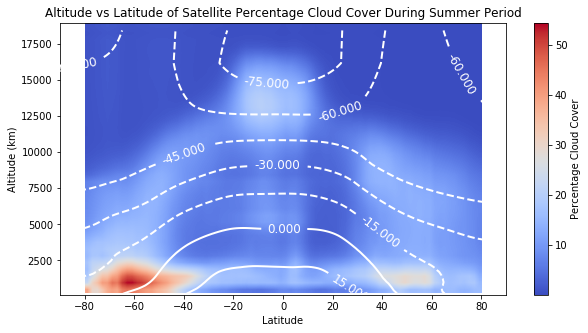

In [256]:
# Plot the altitude vs latitude for summer period for satellite data
title = "Altitude vs Latitude of Satellite Percentage Cloud Cover During Summer Period"
plot_satellite_alt_lat_cloud_cover(avg_sat_summer_cloud_cover, sat_summer_temperatures, title, SIZE)

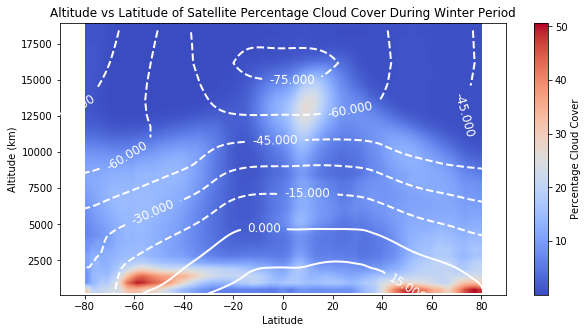

In [257]:
# Plot the altitude vs latitude for winter period for satellite data
title = "Altitude vs Latitude of Satellite Percentage Cloud Cover During Winter Period"
plot_satellite_alt_lat_cloud_cover(avg_sat_winter_cloud_cover, sat_winter_temperatures, title, SIZE)

<br /> <br /><br /> <br />
## Seasonal Model and Satellite Biases

Data for both models has been reduced to an array of $(alt,lat)$ coordinates, however these datasets do not have the same dimensions. To evaluate biases between the model and satellite data, satellite data has been linearly interpolated to be the same size as the model data. Only a subset of the modelled data can be evaluated since the range of latitudes for the model is $-90$ to $90$ compared to only $-80$ to $80$ for the satellite.

In [35]:
# Find the longitudinal and latitudinal coordinates from the model that are within the range of satellite coords
min_model_lat, max_model_lat = find_min_max_indices(cl_data.variables["lat"][:], SAT_LAT_MIN, SAT_LAT_MAX)

# Extract latitudes from model which correspond to latitudes from the satellite data
reduced_model_lat = cl_data.variables["lat"][min_model_lat:max_model_lat]
reduced_model_alt = cl_data.variables["alt40"][:]

BIAS_COLORBAR_LABEL = "Percentage Difference Cloud Cover"

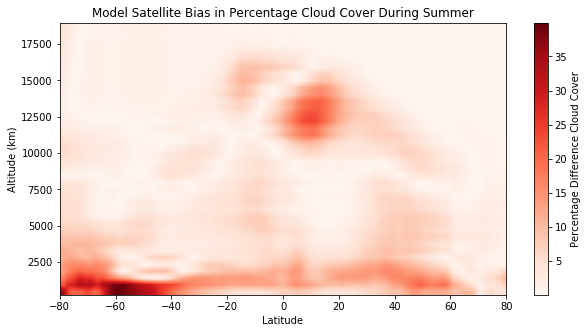

In [36]:
# Interpolate the known satellite cloud coverage data across altitudes and latitudes
interp = interpolate.interp2d(sat_latitudes_alt_lat, sat_altitudes_alt_lat, avg_sat_summer_cloud_cover, kind="cubic")

# Create an interpolated satellite dataset with same dimensions as model
interpolated_sat_alt_lat = interp(reduced_model_lat, reduced_model_alt)

# Generate a subset of the modelled data with same coordinates as satellite data
sat_sized_model_alt_lat = avg_model_summer_cloud_cover[:, min_model_lat:max_model_lat]

# Compute biases
bias = np.absolute(interpolated_sat_alt_lat - sat_sized_model_alt_lat)

title = "Model Satellite Bias in Percentage Cloud Cover During Summer"
plot_alt_lat_cloud_cover(bias, title, SIZE, BIAS_COLORBAR_LABEL).set_cmap("Reds")

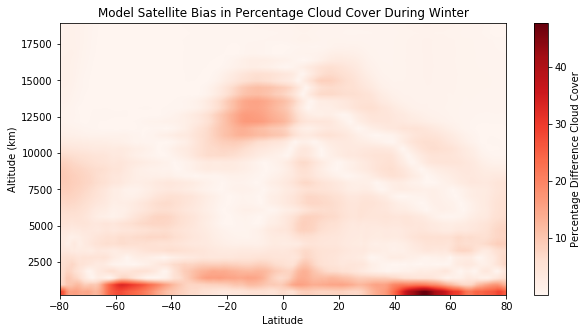

In [37]:
# Interpolate the known satellite cloud coverage data across altitudes and latitudes
interp = interpolate.interp2d(sat_latitudes_alt_lat, sat_altitudes_alt_lat, avg_sat_winter_cloud_cover, kind="cubic")

# Create an interpolated satellite dataset with same dimensions as model
interpolated_sat_alt_lat = interp(reduced_model_lat, reduced_model_alt)

# Generate a subset of the modelled data with same coordinates as satellite data
sat_sized_model_alt_lat = avg_model_winter_cloud_cover[:, min_model_lat:max_model_lat]

# Compute biases
bias = np.absolute(interpolated_sat_alt_lat - sat_sized_model_alt_lat)

title = "Model Satellite Bias in Percentage Cloud Cover During Winter"
plot_alt_lat_cloud_cover(bias, title, SIZE, BIAS_COLORBAR_LABEL).set_cmap("Reds")

<br /> <br /><br /> <br /><br /> <br />
## Regional Cloud Cover: Model Data

From analysing the previous plots showing altitude vs latitude cloud cover for different seasons, three regions of interest for further analysis are evident. These regions are those of the highest cloud coverage, and are centered approximately around $(lat, alt)$ coordinates of $(-50, 1), (70, 1), (0, 12)$. The following code generates altitude vs latitude plots zooming in on these regions of interest. Note the following helper method defined to extract regional data from the model. The regions extracted from the data are using the cl dataset averaged over the time period which overlaps with the satellite data, from 2006-2014. These regions have been named as follows: Region 1 is the region centered at $(-50, 1)$, Region 2 is the region centered at $(70, 1)$, Region 3 is the region centered at $(0, 12)$.

In [38]:
# Average over longitude, then average over time to get array of (alt, lat) for overlap time period between satellite and model
mask = generate_seasonal_time_mask(cl_data.variables["time"][:], None)
avg_cloud_cover_time_overlap = np.mean(np.mean(cl_data.variables["clcalipso"][mask], axis = 3), axis=0)

C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
# Helper method to generate regional plots of cl data 
def generate_regional_plot(region_number, alt_max, alt_min, lat_max, lat_min):
    alt_min_index, alt_max_index = find_min_max_indices(cl_data.variables["alt40"][:], alt_min, alt_max)
    lat_min_index, lat_max_index = find_min_max_indices(cl_data.variables["lat"][:], lat_min, lat_max)

    # Extract the cloud cover data from the coordinates within region 1
    region_cloud_cover = avg_cloud_cover_time_overlap[alt_min_index : alt_max_index, lat_min_index : lat_max_index][::-1]

    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    color_map = plt.imshow(region_cloud_cover, aspect="auto", interpolation='bilinear', 
                        extent=[lat_min, lat_max, alt_min, alt_max])
    color_map.set_cmap("coolwarm")

    plt_title = "Altitude vs Latitude of Average Percentage Cloud Cover in Region " + str(region_number)
    plt.title(plt_title)

    plt.xlabel("Latitude")
    plt.ylabel("Altitude")
    cbar = plt.colorbar()
    cbar.set_label("Percentage Cloud Cover")

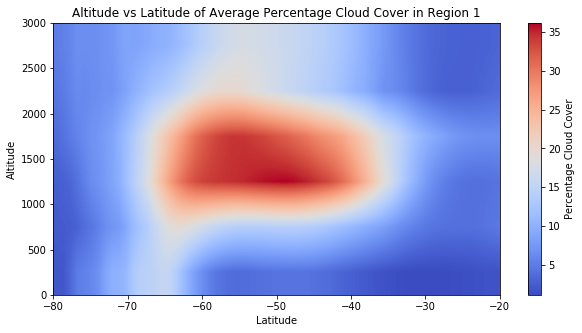

In [30]:
# Plot the average percentage cloud cover over region 1

r1_alt_max = 3000
r1_alt_min = 0
r1_lat_max = -20
r1_lat_min = -80

generate_regional_plot(1, r1_alt_max, r1_alt_min, r1_lat_max, r1_lat_min)

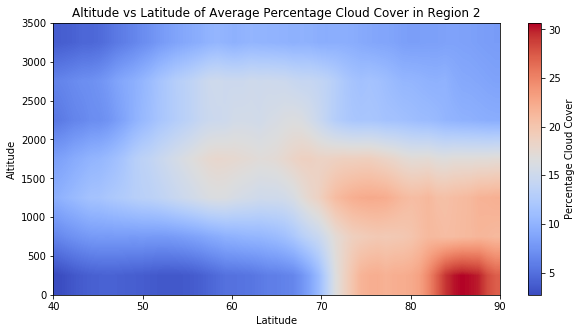

In [31]:
# Plot the average percentage cloud cover over region 2

r2_alt_max = 3500
r2_alt_min = 0
r2_lat_max = 90
r2_lat_min = 40

generate_regional_plot(2, r2_alt_max, r2_alt_min, r2_lat_max, r2_lat_min)

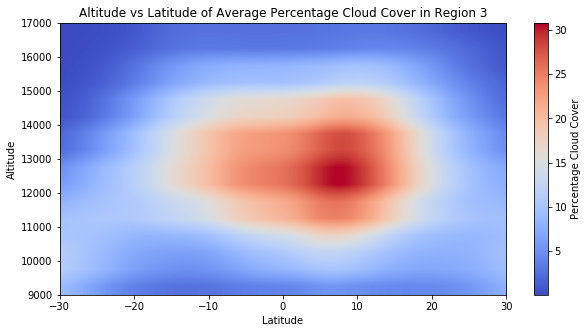

In [32]:
# Plot the average percentage cloud cover over region 3

r3_alt_max = 17000
r3_alt_min = 9000
r3_lat_max = 30
r3_lat_min = -30

generate_regional_plot(3, r3_alt_max, r3_alt_min, r3_lat_max, r3_lat_min)

<br /> <br />
## Regional Cloud Cover: Satellite Data

<br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> <br /> 

# Top of the Atmosphere Cloud Fraction 


## Seasonal Cloud Cover: Model Data

In [36]:
# Extract all time and TOA cloud fraction data from dataset
summer_mask = generate_seasonal_time_mask(clt_data.variables["time"][:], "summer")
winter_mask = generate_seasonal_time_mask(clt_data.variables["time"][:], "winter")

# Find subset of TOA cloud cover for each season
avg_cloud_cover_summer = np.mean(clt_data.variables["cltcalipso"][summer_mask], axis=0)[::-1]
avg_cloud_cover_winter = np.mean(clt_data.variables["cltcalipso"][winter_mask], axis=0)[::-1]
avg_cloud_cover = np.mean(clt_data.variables["cltcalipso"][:], axis=0)[::-1]

model_lon_min = min(clt_data.variables["lon"][:])
model_lon_max = max(clt_data.variables["lon"][:])
model_lat_min = min(clt_data.variables["lat"][:])
model_lat_max = max(clt_data.variables["lat"][:])

C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  
C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  import sys
C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  


In [38]:
def generate_TOA_plot(cloud_cover, title, lon_min, lon_max, lat_min, lat_max, color_bar_label="Percentage Cloud Cover"):

    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    color_map = plt.imshow(cloud_cover, interpolation='nearest', aspect="auto",
                        extent=[lon_min, lon_max, lat_min, lat_max])

    color_map.set_cmap("Blues_r")
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    cbar = plt.colorbar()
    cbar.set_label(color_bar_label)

    return color_map

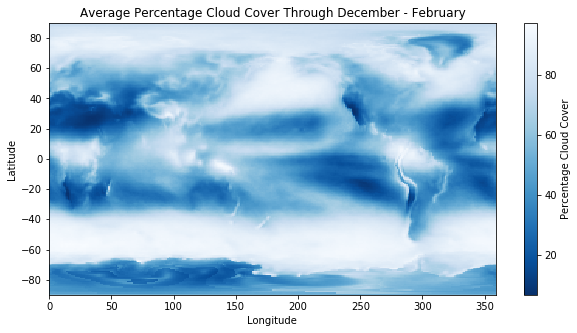

In [39]:
# Plot the average percentage of cloud cover through the summer months
title = "Average Percentage Cloud Cover Through December - February"
generate_TOA_plot(avg_cloud_cover_summer, title, model_lon_min, model_lon_max, model_lat_min, model_lat_max)

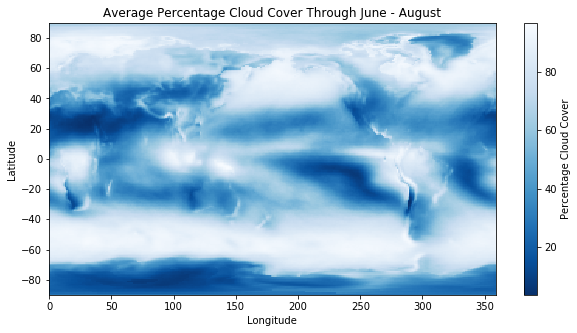

In [40]:
# Plot the average percentage of cloud cover through the winter months
title = "Average Percentage Cloud Cover Through June - August"
generate_TOA_plot(avg_cloud_cover_winter, title, model_lon_min, model_lon_max, model_lat_min, model_lat_max)

## TOA Cloud Cover: Satellite Data
The data provided for top of the atmosphere cloud coverage from satellite readings is already averaged over the time it was collected. This means seasonal cloud coverage times cannot be extracted from the data. The following code instead plots the average TOA cloud coverage over all time. 

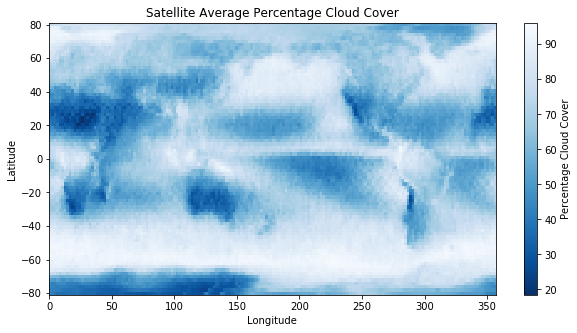

In [41]:
# Convert cloud coverage to a percentage
raw_sat_cloud_coverage = map_low_high_mid_high_data.variables["cltcalipso"][0][::-1] * 100

# Find index position where longitude is closest to 0
lon_0_index = next(x for x, lon in enumerate(map_low_high_mid_high_data.variables["longitude"][:]) if lon >= 0)

# Align longitude coords with those used in model data
rearranged_indices = np.append(range(lon_0_index, len(raw_sat_cloud_coverage[0])), range(0, lon_0_index))
rearranged_sat_cloud_coverage = raw_sat_cloud_coverage[:,rearranged_indices]

# Remove masked data for clt and latitudes
mask = map_low_high_mid_high_data.variables["cltcalipso"][:].mask[0]
sat_cloud_coverage = np.ma.compress_rows(np.ma.MaskedArray(rearranged_sat_cloud_coverage, mask=mask))
sat_latitudes = map_low_high_mid_high_data.variables["latitude"][~mask[:,0]]

# Generate new range of longitudinal data of appropriate size for satellite data ordered to be the same as the model
sat_longitudes = np.arange(0, max(clt_data.variables["lon"][:]), max(clt_data.variables["lon"][:])/len(map_low_high_mid_high_data.variables["longitude"][:]))

sat_lon_min = min(sat_longitudes)
sat_lon_max = max(sat_longitudes)
sat_lat_min = min(sat_latitudes)
sat_lat_max = max(sat_latitudes)

title = "Satellite Average Percentage Cloud Cover"
generate_TOA_plot(sat_cloud_coverage, title, sat_lon_min, sat_lon_max, sat_lat_min, sat_lat_max)

<br /> <br />
## Top of Atmosphere: Model Biases
It is difficult to find the biases between modelled and satellite data, as the size of longitude and latitude data is different between datasets. The satellite longitude and latitude data has thus been interpolated to reshape it to the same dimensions as the modelled data. Both datasets also do not have the same latitudinal range, with satellite data only storing latitude data between around $(-80,80)$ compared with $(-90, 90)$ for model data. To account for this, interpolation has only been completed for latitudinal values within the range of satellite data.

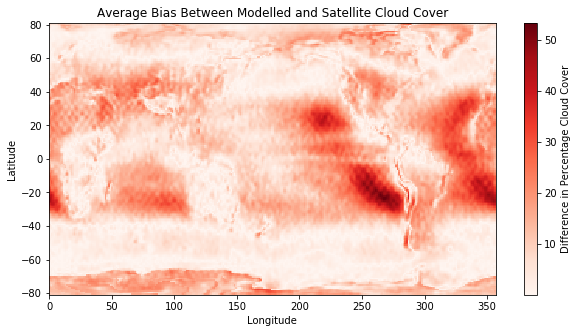

In [42]:
# Find the longitudinal and latitudinal coordinates from the model that are within the range of satellite coords
min_model_lat, max_model_lat = find_min_max_indices(clt_data.variables["lat"][:], sat_lat_min, sat_lat_max)
model_lat = clt_data.variables["lat"][min_model_lat:max_model_lat]
model_lon = clt_data.variables["lon"][:]

# Interpolate the known satellite cloud coverage data across all longitudes and latitudes
interp = interpolate.interp2d(sat_longitudes, sat_latitudes, sat_cloud_coverage, kind="cubic")

# Generate interpolated values for all points of the modelled longitude and latitude data
interpolated_sat_cloud_coverage = interp(model_lon, model_lat)

# Extract the minimised range of latitudinal data from all modelled data
sat_sized_model_cloud_coverage = avg_cloud_cover[min_model_lat:max_model_lat, :]

# Compute biases
bias = np.absolute(interpolated_sat_cloud_coverage - sat_sized_model_cloud_coverage)

title = "Average Bias Between Modelled and Satellite Cloud Cover"
color_bar_label = "Difference in Percentage Cloud Cover"

generate_TOA_plot(bias, title, sat_lon_min, sat_lon_max, sat_lat_min, sat_lat_max, color_bar_label).set_cmap("Reds")

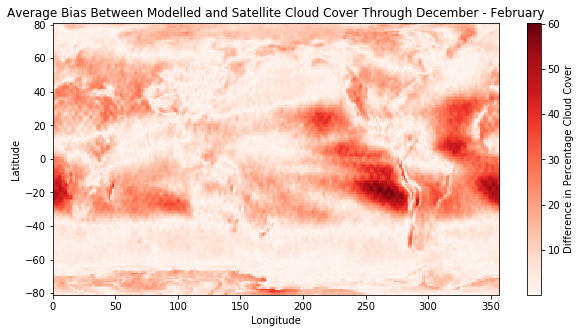

In [43]:
# Extract the minimised range of latitudinal data from all modelled data
sat_sized_model_cloud_coverage = avg_cloud_cover_summer[min_model_lat:max_model_lat, :]

# Compute biases
bias = np.absolute(interpolated_sat_cloud_coverage - sat_sized_model_cloud_coverage)

title = "Average Bias Between Modelled and Satellite Cloud Cover Through December - February"
color_bar_label = "Difference in Percentage Cloud Cover"

generate_TOA_plot(bias, title, sat_lon_min, sat_lon_max, sat_lat_min, sat_lat_max, color_bar_label).set_cmap("Reds")

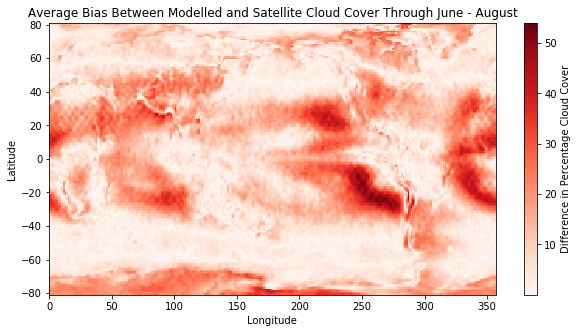

In [44]:
# Extract the minimised range of latitudinal data from all modelled data
sat_sized_model_cloud_coverage = avg_cloud_cover_winter[min_model_lat:max_model_lat, :]

# Compute biases
bias = np.absolute(interpolated_sat_cloud_coverage - sat_sized_model_cloud_coverage)

title = "Average Bias Between Modelled and Satellite Cloud Cover Through June - August"
color_bar_label = "Difference in Percentage Cloud Cover"

generate_TOA_plot(bias, title, sat_lon_min, sat_lon_max, sat_lat_min, sat_lat_max, color_bar_label).set_cmap("Reds")

<br /> <br /> <br /> 
## Regional Cloud Cover: Model Data
The map of biases between modelled and satellite data allows us to observe regions of interest in the longitudinal and latitudinal cloud coverage data. Notably, the regions surrounding the Western coasts of South America and Africa appear to have the largest divergence from modelled predictions. Some notable deviance is also observed between Africa and Australia.

In [45]:
# Helper method to generate regional plots of clt data 
def generate_lon_lat_model_regional_plot(plt_title, lon_min, lon_max, lat_min, lat_max):
    lon_min_index, lon_max_index = find_min_max_indices(clt_data.variables["lon"][:], lon_min, lon_max)
    lat_min_index, lat_max_index = find_min_max_indices(clt_data.variables["lat"][:], lat_min, lat_max)

    # Extract the cloud cover data from the coordinates within region 1
    # Flip cloud cover to restore original latitude ordering then reorder
    cover = avg_cloud_cover[::-1]
    region_cloud_cover = cover[lat_min_index : lat_max_index, lon_min_index : lon_max_index][::-1]

    generate_TOA_plot(region_cloud_cover, plt_title, lon_min, lon_max, lat_min, lat_max)

# Helper method to generate regional plots of clt data 
def generate_lon_lat_satellite_regional_plot(plt_title, lon_min, lon_max, lat_min, lat_max):
    lon_min_index, lon_max_index = find_min_max_indices(model_lon, lon_min, lon_max)
    lat_min_index, lat_max_index = find_min_max_indices(model_lat, lat_min, lat_max)

    # Extract the cloud cover data from the coordinates within region 1
    # Flip cloud cover to restore original latitude ordering then reorder
    cover = interpolated_sat_cloud_coverage[::-1]
    region_cloud_cover = cover[lat_min_index : lat_max_index, lon_min_index : lon_max_index][::-1]

    generate_TOA_plot(region_cloud_cover, plt_title, lon_min, lon_max, lat_min, lat_max)

# Helper method to generate regional plots of clt data 
def generate_lon_lat_bias_regional_plot(plt_title, lon_min, lon_max, lat_min, lat_max):
    lon_min_index, lon_max_index = find_min_max_indices(model_lon, lon_min, lon_max)
    lat_min_index, lat_max_index = find_min_max_indices(model_lat, lat_min, lat_max)

    # Extract the cloud cover data from the coordinates within region 1
    # Flip cloud cover to restore original latitude ordering then reorder
    cover = interpolated_sat_cloud_coverage[::-1]
    sat_region_cloud_cover = cover[lat_min_index : lat_max_index, lon_min_index : lon_max_index][::-1]


    lon_min_index, lon_max_index = find_min_max_indices(clt_data.variables["lon"][:], lon_min, lon_max)
    lat_min_index, lat_max_index = find_min_max_indices(clt_data.variables["lat"][:], lat_min, lat_max)

    # Extract the cloud cover data from the coordinates within region 1
    # Flip cloud cover to restore original latitude ordering then reorder
    cover = avg_cloud_cover[::-1]
    model_region_cloud_cover = cover[lat_min_index : lat_max_index, lon_min_index : lon_max_index][::-1]

    bias = np.absolute(sat_region_cloud_cover - model_region_cloud_cover)

    generate_TOA_plot(bias, plt_title, lon_min, lon_max, lat_min, lat_max).set_cmap("Reds")
    

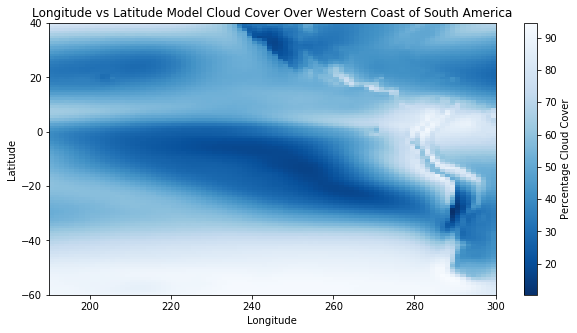

In [46]:
r1_lon_max = 300
r1_lon_min = 190
r1_lat_max = 40
r1_lat_min = -60

plt_title = "Longitude vs Latitude Model Cloud Cover Over Western Coast of South America"
generate_lon_lat_model_regional_plot(plt_title, r1_lon_min, r1_lon_max, r1_lat_min, r1_lat_max)

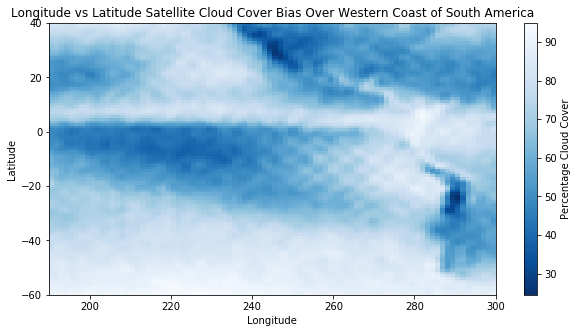

In [47]:
plt_title = "Longitude vs Latitude Satellite Cloud Cover Bias Over Western Coast of South America"
generate_lon_lat_satellite_regional_plot(plt_title, r1_lon_min, r1_lon_max, r1_lat_min, r1_lat_max)

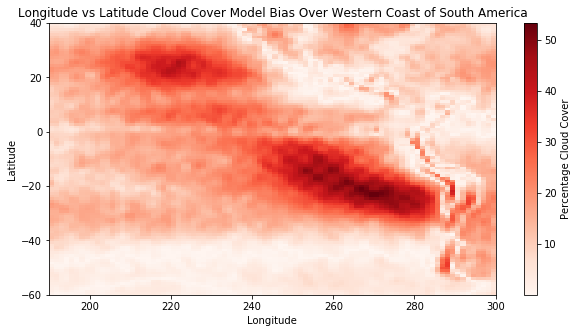

In [48]:
plt_title = "Longitude vs Latitude Cloud Cover Model Bias Over Western Coast of South America"
generate_lon_lat_bias_regional_plot(plt_title, r1_lon_min, r1_lon_max, r1_lat_min, r1_lat_max)

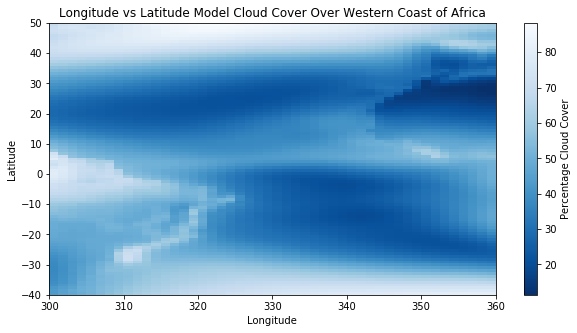

In [49]:
r2_lon_max = 360
r2_lon_min = 300
r2_lat_max = 50
r2_lat_min = -40

plt_title = "Longitude vs Latitude Model Cloud Cover Over Western Coast of Africa"
generate_lon_lat_model_regional_plot(plt_title, r2_lon_min, r2_lon_max, r2_lat_min, r2_lat_max)

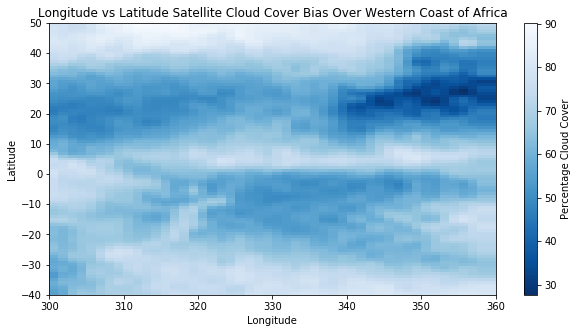

In [50]:
plt_title = "Longitude vs Latitude Satellite Cloud Cover Bias Over Western Coast of Africa"
generate_lon_lat_satellite_regional_plot(plt_title, r2_lon_min, r2_lon_max, r2_lat_min, r2_lat_max)

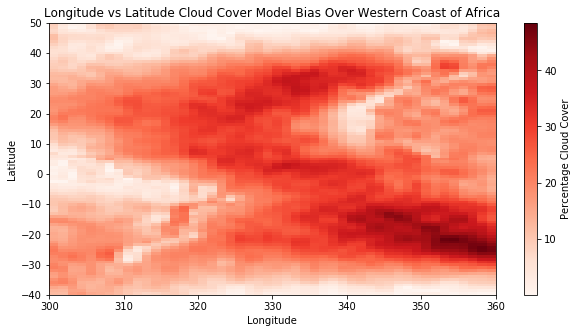

In [51]:
plt_title = "Longitude vs Latitude Cloud Cover Model Bias Over Western Coast of Africa"
generate_lon_lat_bias_regional_plot(plt_title, r2_lon_min, r2_lon_max, r2_lat_min, r2_lat_max)